## Data Tokenization and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import datasets

In [2]:
articles = datasets.load_dataset('online_news_popularity_data')

Found cached dataset online_news_popularity_data (/home/leeparkuky/.cache/huggingface/datasets/online_news_popularity_data/online_news_popularity_data/1.0.0/63eb244b62e86df6ad3ae3034fcbddd6ed2840885e607a97d5e8f49afab926e0)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
from transformers import AutoTokenizer
ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(ckpt)

In [4]:
def concatenate_fernandes_variables(examples):
    fernandes = [val for key, val in examples.items() if key not in ['title','content','shares','shares_class']]
    fernandes = np.array(fernandes).T.tolist()
    return {'fernandes': fernandes}

In [5]:
articles_concat = articles.map(concatenate_fernandes_variables, batched = True, batch_size = 64, num_proc = 16,
                              remove_columns = [x for x in articles.column_names['train'] if x not in ['title','content','shares','shares_class']] )

Loading cached processed dataset at /home/leeparkuky/.cache/huggingface/datasets/online_news_popularity_data/online_news_popularity_data/1.0.0/63eb244b62e86df6ad3ae3034fcbddd6ed2840885e607a97d5e8f49afab926e0/cache-d040c91994313900_*_of_00016.arrow


In [6]:
def tokenize(examples):
    text = [title + content for title, content in zip(examples['title'], examples['content'])]
    inputs = tokenizer(text, max_length = 1500, truncation = True, padding = False)
    N = len(inputs['input_ids'])
    fernandes_list = []
    for i, input_ids in enumerate(inputs['input_ids']):
        fernandes_list.append([examples['fernandes'][i] for _ in range(len(input_ids))])
    inputs.update({'fernandes':fernandes_list})
    return inputs

In [7]:
articles_tokenized = articles_concat.map(tokenize, batched = True, batch_size = 64, num_proc = 16,
                   remove_columns = ['shares','shares_class','title','content'])

Loading cached processed dataset at /home/leeparkuky/.cache/huggingface/datasets/online_news_popularity_data/online_news_popularity_data/1.0.0/63eb244b62e86df6ad3ae3034fcbddd6ed2840885e607a97d5e8f49afab926e0/cache-fc1b51a92fbd27c3_*_of_00016.arrow


In [8]:
articles_tokenized

DatasetDict({
    train: Dataset({
        features: ['fernandes', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 39608
    })
})

In [9]:
from collections import defaultdict

def split_inputs_by_512(examples):
    result = defaultdict(list)
    for key, vec in examples.items():
        vec = [np.array(v) for v in vec]
        vec = np.concatenate(vec)
        size = 512
        remaining = 512
        idx = 0
        while remaining >= 512:
            result[key].append(vec[idx*size:(idx+1)*size].tolist())
            remaining = vec[(idx+1)*size:].shape[0]
            idx += 1
    return result

In [10]:
articles_tokenized = articles_tokenized.shuffle().map(split_inputs_by_512, batched = True, batch_size = 128, num_proc = 16)

Map (num_proc=16):   0%|          | 0/39608 [00:00<?, ? examples/s]

In [11]:
articles_tokenized

DatasetDict({
    train: Dataset({
        features: ['fernandes', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 41661
    })
})

In [12]:
articles_tokenized.set_format('pt')

In [13]:
articles_tokenized = articles_tokenized['train'].train_test_split(.05)

# Tesing if "MashableBertForMaskedLM" works

In [14]:
# from Transformer_Models import MashableBertForMaskedLM

# model_ckpt = 'bert-base-uncased'
# model = MashableBertForMaskedLM(model_ckpt)

In [15]:
# model(**{k:v for k,v in articles_tokenized['train'][:3].items()})

# Organizing Training Job for MaskedLM

In [16]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

In [17]:
from Transformer_Models import MashableBertForMaskedLM

model_ckpt = 'bert-base-uncased'
model = MashableBertForMaskedLM(model_ckpt)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
from pynvml import *


def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

In [19]:
print_gpu_utilization()

GPU memory occupied: 659 MB.


In [22]:
from transformers import TrainingArguments, Trainer
import torch

training_args = TrainingArguments(
    output_dir="pretraining-mashablebert",
    overwrite_output_dir = True,
    evaluation_strategy="epoch",
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 4,
    fp16 = True,
    learning_rate=2e-5,
    num_train_epochs=40,
    weight_decay=0.01,
    push_to_hub=False,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    optim = 'adafactor',
    save_total_limit = 10
)


trainer = Trainer(
    model=model.to(torch.device('cuda')),
    args=training_args,
    train_dataset=articles_tokenized["train"],
    eval_dataset=articles_tokenized["test"],
    data_collator=data_collator,
)



In [23]:
print_gpu_utilization()

GPU memory occupied: 1695 MB.


In [ ]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,4.518000,3.946904
2,3.713900,3.284673
3,3.155800,2.928413
4,2.919900,2.678311
5,2.690000,2.522423
6,2.566700,2.398677
7,2.427900,2.300735
8,2.355600,2.203932
9,2.260200,2.148008
10,2.214200,2.103539


In [32]:
trainer.save_model('MashableBertForMaskedLM_Pretrained')

In [44]:
from Transformer_Models import MashableBertModel

bertmodel = MashableBertModel('MashableBertForMaskedLM_Pretrained')
# bertmodel.load_state_dict(torch.load('sample_weight.pth'))

In [61]:
weights = torch.load('MashableBertForMaskedLM_Pretrained/pytorch_model.bin')

In [62]:
# rename keys, drop unused keys for basemodel, then save the weights
for key in [key for key in weights.keys() if key[5:] not in bertmodel.state_dict().keys()]:
    del weights[key]
for key in [key for key in weights.keys() if key[5:] in bertmodel.state_dict().keys()]:
    weights[key[5:]] = weights[key]
    del weights[key]


In [63]:
bertmodel.load_state_dict(weights)

<All keys matched successfully>

In [57]:
#Finally save the basemodel weight in Model Weights folder
torch.save(bertmodel.state_dict(), 'Model Weights/MashableBertModel_Pretrained.pth')

### Apendix: Training and Validation Loss Per Epoch Table

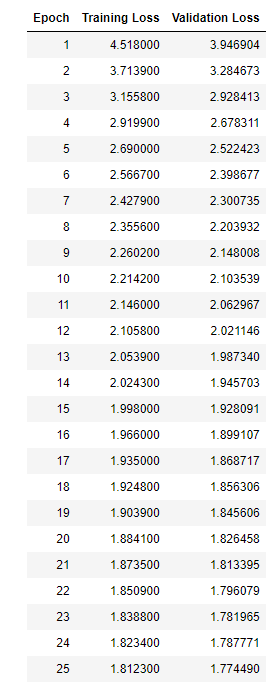